<a href="https://colab.research.google.com/github/melixxa07/DeepLearning-Project/blob/main/01_Emotion_Recognition_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color ="royalblue"> <font face = 'Century'> -- **Emotion Recognition: FER-2013** --

<font face = 'Century'>  Data Source: [FER-2013 - Kaggle ](https://www.kaggle.com/datasets/msambare/fer2013)



 📌<font face = 'Century'> **Recommendation:** Enable GPU acceleration in Google Colab for optimal notebook performance.

<font face = 'Century'> `Runtime > Change runtime type > Hardware accelerator > T4 GPU > Save`






<font face = 'Century'>

<font face = 'Century'> Run the cell bellow to import the libraries:

In [1]:
# General libraries
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# Data handling
import os
import zipfile
from PIL import Image
# Data preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Model architecture
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

<font face = 'Century'> Download the dataset from Kaggle:

In [2]:
# Download the dataset using the dataset ID in Kaggle
!kaggle datasets download -d msambare/fer2013 -p /content/dataset

# Unzip the downloaded zip file
with zipfile.ZipFile('/content/dataset/fer2013.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 99% 60.0M/60.3M [00:03<00:00, 24.0MB/s]
100% 60.3M/60.3M [00:03<00:00, 18.8MB/s]


<font face = 'Century'>

<p><a name="contents"></a></p>

### <font face = 'Century'> **Contents**
1. <a href="#Data Preprocessing">Data Preprocessing</a><br>
  * <a href="#Data Exploration">Data Exploration</a><br>
  * <a href="#Data Normalization">Data Normalization</a><br>
  * <a href="#Data Augmentation">Data Augmentation</a><br>
  * <a href="#Data Shuffling">Data Shuffling</a><br>
  * <a href="#Data Splitting">Data Splitting</a><br>
2. <a href="#Convolutional Neural Network Models">Convolutional Neural Network Models</a><br>
  * <a href="#First Simple CNN Model">First simple CNN model</a><br>
  * <a href="#Custom CNN Model Architectures">Custom CNN model architectures</a><br>
3. <a href="#Model Evaluation">Model Evaluation</a><br>
  * <a href="#Saving Models">Saving Models</a><br>
  * <a href="#Model Evaluation On Test Data">Model Evaluation On Test Data</a><br>
  * <a href="#Performance Evaluation">Performance Evaluation</a><br>
4. <a href="#Different Approaches">Different Approaches</a><br>
  * <a href="#Feature Extraction + ML Algorithms">Feature Extraction + ML Algorithms</a><br>
  * <a href="#Transfer Learning">Transfer Learning</a><br>



<font face = 'Century'>

<p><a name="Cleaning Dataset"></a></p>

## <font color ="royalblue"> <font face = 'Century' > Data Preprocessing

<p><a name="Data Exploration"></a></p>

### <font color ="royalblue"> <font face = 'Century' > Data Exploration:

 <font face = 'Century'> Folder contents:

In [3]:
print('FER-2013:', os.listdir('/content/dataset'))
print('Train:', os.listdir('/content/dataset/train'))
print('Test:', os.listdir('/content/dataset/test'))

FER-2013: ['fer2013.zip', 'train', 'test']
Train: ['happy', 'fear', 'surprise', 'neutral', 'sad', 'angry', 'disgust']
Test: ['happy', 'fear', 'surprise', 'neutral', 'sad', 'angry', 'disgust']


In [4]:
print('-- Train Dataset --')
for folder in os.listdir('/content/dataset/train'):
  print(folder,':', len(os.listdir('/content/dataset/train/' + folder)))

print('')
print('-- Test Dataset --')
for folder in os.listdir('/content/dataset/test'):
  print(folder, ':', len(os.listdir('/content/dataset/test/' + folder)))

-- Train Dataset --
happy : 7215
fear : 4097
surprise : 3171
neutral : 4965
sad : 4830
angry : 3995
disgust : 436

-- Test Dataset --
happy : 1774
fear : 1024
surprise : 831
neutral : 1233
sad : 1247
angry : 958
disgust : 111


<font face = 'Century'>

<font face = 'Century'>Let's read all the files and add them in their respective arrays.

> <font face = 'Century'>  _Function to read all `train` and `test` files:_



In [5]:
def load_and_process_data(wd):
  # We create the variables we need in the neural network
  pictures = []
  labels = []

  # Let's add the counters
  happy = 0
  sad = 0
  angry = 0
  neutral = 0
  surprised = 0
  fearful = 0
  disgusted = 0
  excluded = 0

  # Let's read the folders in train:
  for folder in os.listdir(wd):
    folder_path = os.path.join(wd, folder)
    if os.path.isdir(folder_path):
      for file in os.listdir(folder_path):

        try:
          dir = os.path.join(folder_path,file)
          with Image.open(dir) as img:
            #img = img.resize((48, 48), Image.LANCZOS)   # Images are already 48x48 and grayscale
            img = np.array(img) # Since all the images have the same size, we just convert it into an array
            img = np.expand_dims(img, axis=-1) # This is to add an extra channel with number 1 that represents grayscale images
            pictures.append(img)

          if 'happy' in folder:
            labels.append(0)
            happy += 1              # This is the amount of happy images
          elif 'sad' in folder:
            labels.append(1)
            sad += 1                # This is the amount of sad images
          elif 'angry' in folder:
            labels.append(2)
            angry += 1
          elif 'neutral' in folder:
            labels.append(3)
            neutral += 1
          elif 'surprise' in folder:
            labels.append(4)
            surprised += 1
          elif 'fear' in folder:
            labels.append(5)
            fearful += 1
          elif 'disgust' in folder:
            labels.append(6)
            disgusted += 1

        except: excluded += 1       # This is the amount of excluded images

  # With all the information added, let's create an array of the images an their respective labels
  pictures = np.array(pictures)
  labels = np.array(labels)

  print(pictures.shape, labels.shape)
  print('Happy:', happy)
  print('Sad:', sad)
  print('Angry:', angry)
  print('Neutral:', neutral)
  print('Surprise:', surprised)
  print('Fear:', fearful)
  print('Disgust:', disgusted)

  # print(excluded, 'excluded because of size')
  return pictures, labels

<font face = 'Century'>Let's define class names:

In [6]:
class_names = ['Happy', 'Sad', 'Angry', 'Neutral', 'Surprise', 'Fear', 'Disgust']

<font face = 'Century'>

<font face = 'Century'><font color ="royalblue">  **Train dataset:**

In [7]:
X_train, y_train = load_and_process_data('/content/dataset/train')

(28709, 48, 48, 1) (28709,)
Happy: 7215
Sad: 4830
Angry: 3995
Neutral: 4965
Surprise: 3171
Fear: 4097
Disgust: 436


<font face = 'Century'><font color ="royalblue">  **Test dataset:**

In [8]:
X_test, y_test = load_and_process_data('/content/dataset/test')

(7178, 48, 48, 1) (7178,)
Happy: 1774
Sad: 1247
Angry: 958
Neutral: 1233
Surprise: 831
Fear: 1024
Disgust: 111


<font face = 'Century'>

<font face = 'Century'> Data distribution visualization:

Unique label Train: [0 1 2 3 4 5 6]
Count unique label Train: [7215 4830 3995 4965 3171 4097  436]

Unique label Test: [0 1 2 3 4 5 6]
Count unique label Test: [1774 1247  958 1233  831 1024  111]



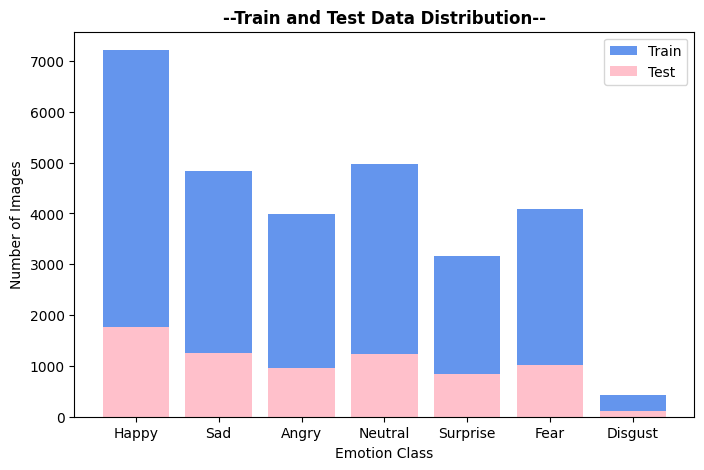

In [9]:
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
print('Unique label Train:', unique_labels_train)
print('Count unique label Train:', counts_train)
print('')
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
print('Unique label Test:', unique_labels_test)
print('Count unique label Test:', counts_test)
print('')

plt.subplots(figsize=(8, 5))
plt.bar(class_names, counts_train, color='cornflowerblue')
plt.bar(class_names, counts_test, color='pink')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.title('--Train and Test Data Distribution--', fontweight='bold')
plt.legend(['Train', 'Test'])
plt.show()


<font face = 'Century'>

<p><a name="Data Normalization"></a></p>

### <font color ="royalblue"> <font face = 'Century' > Data Normalization:

<font face = 'Century'> Let's normalize the data for both, `train` and `test` dataset:

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
X_train[0]

array([[[0.84705882],
        [0.81568627],
        [0.81568627],
        ...,
        [0.19607843],
        [0.19607843],
        [0.16470588]],

       [[0.85490196],
        [0.83137255],
        [0.76078431],
        ...,
        [0.19215686],
        [0.19607843],
        [0.15294118]],

       [[0.84313725],
        [0.85098039],
        [0.64313725],
        ...,
        [0.20784314],
        [0.19215686],
        [0.16470588]],

       ...,

       [[0.14509804],
        [0.12941176],
        [0.11764706],
        ...,
        [0.14117647],
        [0.13333333],
        [0.14509804]],

       [[0.1254902 ],
        [0.13333333],
        [0.13333333],
        ...,
        [0.11764706],
        [0.1254902 ],
        [0.12941176]],

       [[0.14117647],
        [0.1372549 ],
        [0.13333333],
        ...,
        [0.10980392],
        [0.1372549 ],
        [0.12941176]]])

<font face = 'Century'>

<p><a name="Data Augmentation"></a></p>

### <font color ="royalblue"> <font face = 'Century' > Data Augmentation:

<font face = 'Century'> The data augmentation is going to be applied on the classes with the fewest samples such as: `Disgust`, `Surprise`, `Angry` and `Fear`, to enhace their representation and improve overall **data balance**.

<font face = 'Century'> The following augmentation techniques will be applied to ensure that the expression and meaning of the emotions remain unchanged:
- Rotation
- Horizontal flip
- Zooming
- Brightness or contrast adjustment
- Cropping or slight traslation
- Gaussian noise

<font face = 'Century'>Let's define the following functions:

> <font face = 'Century'> _**a.** Gaussian noise_

In [12]:
def add_gaussian_noise(image, mean=0, std=0.02):  # Adjust std for normalized range
          gaussian_noise = np.random.normal(mean, std, image.shape)
          noisy_image = np.clip(image + gaussian_noise, 0, 1)  # Clip to 0-1
          return noisy_image

> <font face = 'Century'> _**b.** Brightness_

In [13]:
def adjust_brightness(image, factor=1.2):
  return np.clip(image * factor, 0 , 1)

> <font face = 'Century'> _**c.** Combined preprocessing function_

In [14]:
def combined_preprocessing(image, apply_noise=False):
  image = adjust_brightness(image)

  if apply_noise:
    image = add_gaussian_noise(image)

  return image

<font face = 'Century'>

<font face = 'Century'> Data Generation:

In [15]:
datagen = ImageDataGenerator(
    rotation_range=20,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    preprocessing_function=combined_preprocessing
    )

<font face = 'Century'> Plotting the augmented images alongside the original image to visualize the effect of augmentation on one image of the dataset:

In [16]:
def plot_augmented_images(image, datagen, num_images=8):

  # Reshape the image to have a batch dimension
  image = image.reshape((1,) + image.shape)

  # Let's generate augmented images
  aug_img = datagen.flow(image, batch_size=1)

  fig, axs = plt.subplots(1, num_images + 1, figsize=(15, 5))
  # Original image:
  axs[0].imshow(image[0].squeeze(), cmap='gray')
  axs[0].set_title('Original Image')
  axs[0].axis('off')
  # Augmented images:
  for i in range(num_images):
    aug_imgs = next(aug_img)
    axs[i + 1].imshow(aug_imgs[0].squeeze(), cmap='gray')
    axs[i + 1].set_title(f'Augmented {i + 1}')
    axs[i + 1].axis('off')

  plt.show()

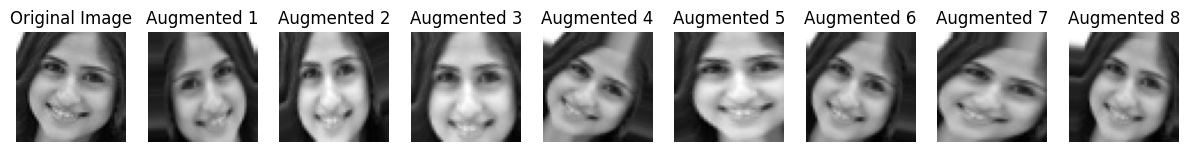

In [17]:
plot_augmented_images(X_train[0], datagen, num_images=8)

<font face = 'Century'>

<font face = 'Century'> The target labels for each emotion class selected for augmentation and the respective number of images to be generated are as follows:

- <font face = 'Century'>  `Disgust (Label 6):` 1600 images
- `Surprise (Label 4):`  2000 images
- `Angry (Label 2):` 1500 images
- `Fear (label 5):` 1500 images


In [18]:
class_labels = [6, 4, 2, 5]
aug_images = [1600, 2000, 1500, 1500]

In [19]:
index_disgust = np.where(y_train == 6)[0]
index_surprise = np.where(y_train == 4)[0]
index_angry = np.where(y_train == 2)[0]
index_fear = np.where(y_train == 5)[0]

> <font face = 'Century'>  _Function to apply **data augmentation** in different data classes:_


In [20]:
def augmentation(X_train_class, index):
  X_class_aug = np.empty((0, 48, 48, 1))

  while len(X_class_aug) < aug_images[index]:
    for image in X_train_class:
      if len(X_class_aug) >= aug_images[index]:
        break

      augmented_data = datagen.flow(np.array([image]), batch_size=1)
      images = next(augmented_data)

      X_class_aug = np.vstack((X_class_aug, images))

  y_class_aug = np.full(aug_images[index], class_labels[index])

  return X_class_aug, y_class_aug

> <font face = 'Century'>  _Function to plot some samples of original and augmented data:_

In [21]:
def aug_plot(original_image, augmented_image):
    fig, axs = plt.subplots(3, 2, figsize=(4, 5))

    for i in range(3):
      # Original image:
      axs[i, 0].imshow(original_image[i], cmap='gray')
      axs[i, 0].axis('off')
      axs[0, 0].set_title('Original Image')

      # Augmented image:
      axs[i, 1].imshow(augmented_image[i].squeeze(), cmap='gray')
      axs[i, 1].axis('off')
      axs[0, 1].set_title('Augmented Image')

    plt.show()
    return

<font face = 'Century'>

- <font face = 'Century'> **Disgust:**

In [22]:
X_train_disgust = X_train[index_disgust]
y_train_disgust = y_train[index_disgust]

In [23]:
X_disgust_aug, y_disgust_aug = augmentation(X_train_disgust, 0)

In [24]:
print('X shape:', X_disgust_aug.shape)
print('y shape:', y_disgust_aug.shape)
print('labels:', y_disgust_aug[:5])

X shape: (1600, 48, 48, 1)
y shape: (1600,)
labels: [6 6 6 6 6]


<font face = 'Century'> Let's check some augmented images generated for `disgust`:

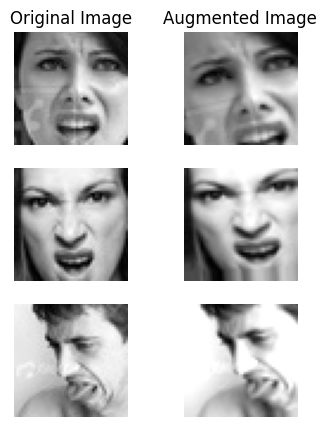

In [25]:
aug_plot(X_train_disgust, X_disgust_aug)

- <font face = 'Century'> **Surprise:**

In [26]:
X_train_surprise = X_train[index_surprise]
y_train_surprise = y_train[index_surprise]

In [27]:
X_surprise_aug, y_surprise_aug = augmentation(X_train_surprise, 1)

In [28]:
print('X shape:', X_surprise_aug.shape)
print('y shape:', y_surprise_aug.shape)
print('labels:', y_surprise_aug[:5])

X shape: (2000, 48, 48, 1)
y shape: (2000,)
labels: [4 4 4 4 4]


<font face = 'Century'> Let's check some augmented images generated for `surprise`:

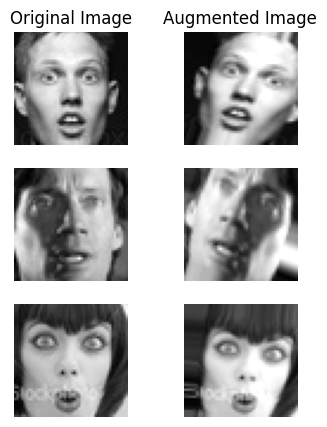

In [29]:
aug_plot(X_train_surprise, X_surprise_aug)

- <font face = 'Century'> **Angry:**

In [30]:
X_train_angry = X_train[index_angry]
y_train_angry = y_train[index_angry]

In [31]:
X_angry_aug, y_angry_aug = augmentation(X_train_angry, 2)

In [32]:
print('X shape:', X_angry_aug.shape)
print('y shape:', y_angry_aug.shape)
print('labels:', y_angry_aug[:5])

X shape: (1500, 48, 48, 1)
y shape: (1500,)
labels: [2 2 2 2 2]


<font face = 'Century'> Let's check some augmented images generated for `angry`:

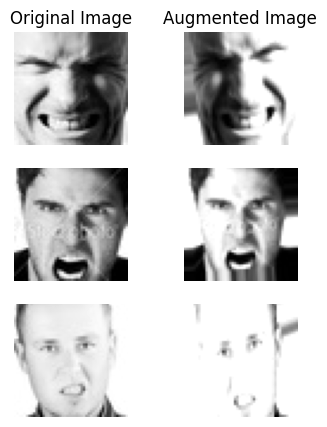

In [33]:
aug_plot(X_train_angry, X_angry_aug)

- <font face = 'Century'> **Fear:**

In [34]:
X_train_fear = X_train[index_fear]
y_train_fear = y_train[index_fear]

In [35]:
X_fear_aug, y_fear_aug = augmentation(X_train_fear, 3)

In [36]:
print('X shape:', X_fear_aug.shape)
print('y shape:', y_fear_aug.shape)
print('labels:', y_fear_aug[:5])

X shape: (1500, 48, 48, 1)
y shape: (1500,)
labels: [5 5 5 5 5]


<font face = 'Century'> Let's check some augmented images generated for `fear`:

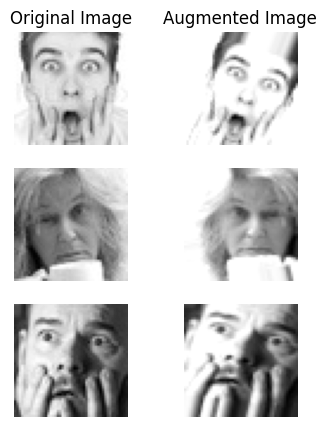

In [37]:
aug_plot(X_train_fear, X_fear_aug)

<font face = 'Century'>

<font face = 'Century'> Let's concatenate the augmented data with the original dataset:

In [38]:
X_train = np.concatenate((X_train, X_disgust_aug, X_surprise_aug, X_angry_aug, X_fear_aug), axis=0)
y_train = np.concatenate((y_train, y_disgust_aug, y_surprise_aug, y_angry_aug, y_fear_aug), axis=0)

In [39]:
y_train.shape

(35309,)

In [40]:
np.sum(aug_images)+ len(X_train)

41909

In [41]:
X_train.shape, y_train.shape

((35309, 48, 48, 1), (35309,))

<font face = 'Century'>

<p><a name="Data Shuffling"></a></p>

### <font color ="royalblue"> <font face = 'Century' > Data Shuffling:

<font face = 'Century'>Let's see how is the data distributed:

In [42]:
y_train[:10], y_train[10000:10010], y_train[20500:20510]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

<font face = 'Century'> As observed, all the data is sorted by class. However, to train the model properly, it is essential to shuffle the data to reduce **bias** and ensure model **generalization**.

> <font face = 'Century'>  _Funciton to shuffle `pictures` and `labels` data:_


In [43]:
def unison_shuffled_data(a, b):

    assert len(a) == len(b)
    i = np.random.permutation(len(a))
    return a[i], b[i]

<font face = 'Century'>Shuffled data of train dataset:

In [44]:
X_train, y_train = unison_shuffled_data(X_train, y_train)

<font face = 'Century'>Let's check:

In [45]:
y_train[:15]

array([6, 0, 2, 2, 4, 4, 4, 2, 0, 6, 4, 3, 3, 0, 1])

Label: 6
Emotion: Disgust


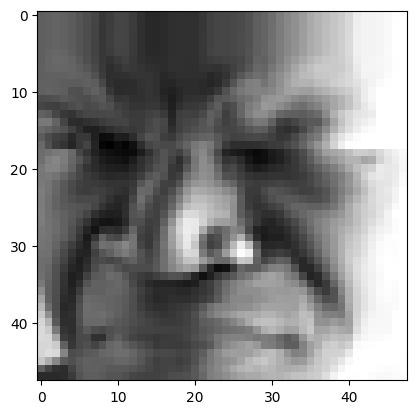

In [46]:
plt.imshow(X_train[0], cmap='gray')
print('Label:', y_train[0])
print('Emotion:', class_names[y_train[0]])

Label: 2
Emotion: Angry


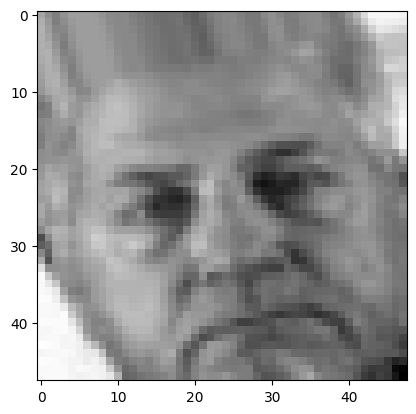

In [47]:
plt.imshow(X_train[2], cmap='gray')
print('Label:', y_train[2])
print('Emotion:', class_names[y_train[2]])

Label: 4
Emotion: Surprise


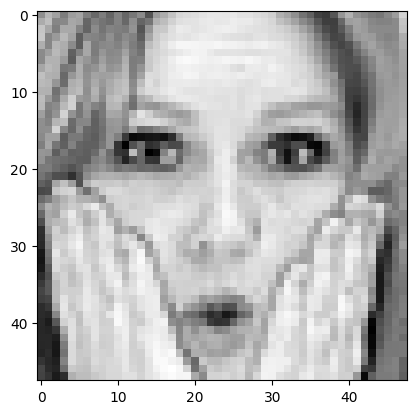

In [48]:
plt.imshow(X_train[4], cmap='gray')
print('Label:', y_train[4])
print('Emotion:', class_names[y_train[4]])

<font face = 'Century'> The `test` set is going to remain **unshuffled** to mantain the **reproducibility** of the final evaluation enabling accurate **perfomance tracking** and **model comparison**.

<font color ="royalblue">

<p><a name="Data Splitting"></a></p>

### <font color ="royalblue"> <font face = 'Century' > Data Splitting:


<font face = 'Century'> The `X_train` dataset is going to be divided into **_training_** and **_validation_** sets, ensuring that both maintain similar class distribution:

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)

In [50]:
print('Train Distribution:', X_train.shape, y_train.shape)
print('Validation Distribution:', X_val.shape, y_val.shape)
print('Test Distribution:', X_test.shape, y_test.shape)

Train Distribution: (28247, 48, 48, 1) (28247,)
Validation Distribution: (7062, 48, 48, 1) (7062,)
Test Distribution: (7178, 48, 48, 1) (7178,)


<font face = 'Century'> **Data distribution visualization:**

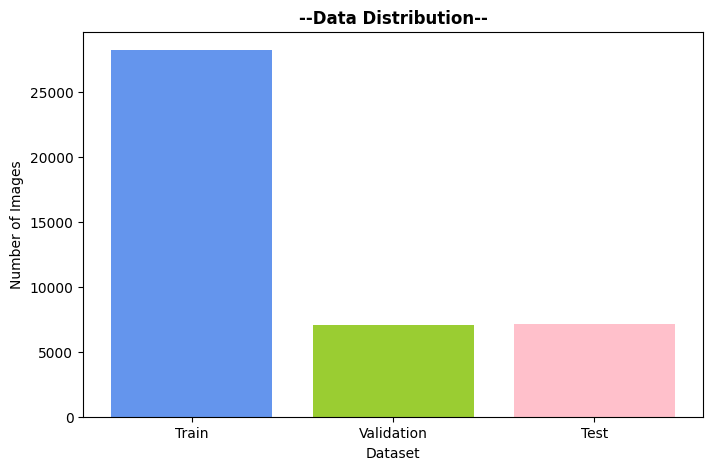

In [51]:
train_count = len(y_train)
val_count = len(y_val)
test_count = len(y_test)

datasets = ['Train', 'Validation', 'Test']
counts = [train_count, val_count, test_count]

plt.subplots(figsize=(8, 5))
plt.bar(datasets, counts, color=['cornflowerblue', 'yellowgreen', 'pink'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('--Data Distribution--', fontweight='bold')
plt.show()

<font face = 'Century'> Now, let's analyze how the images are distributed by class within the datasets:

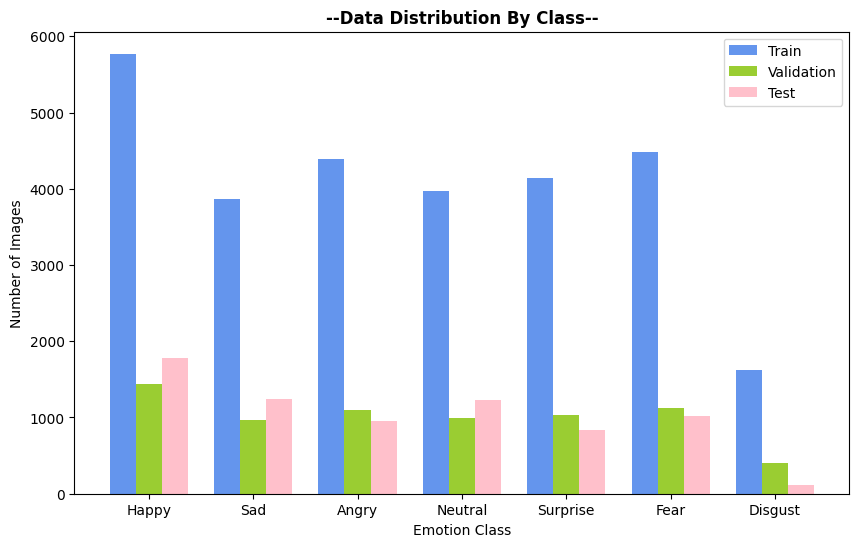

In [52]:
from collections import Counter

# Count occurrences of each class in each dataset
train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)

# Ensure we get counts for each class, even if some classes are missing in a split
train_distribution = [train_counts.get(i, 0) for i in range(len(class_names))]
val_distribution = [val_counts.get(i, 0) for i in range(len(class_names))]
test_distribution = [test_counts.get(i, 0) for i in range(len(class_names))]

# Bar width and positions
bar_width = 0.25
index = np.arange(len(class_names))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(index, train_distribution, bar_width, color='cornflowerblue', label='Train')
plt.bar(index + bar_width, val_distribution, bar_width, color='yellowgreen', label='Validation')
plt.bar(index + 2 * bar_width, test_distribution, bar_width, color='pink', label='Test')

# Labels and title
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.title('--Data Distribution By Class--', fontweight='bold')
plt.xticks(index + bar_width, class_names)
plt.legend()

plt.show()

In [53]:
print('--Train--')
unique_labels_train_, counts_train_ = np.unique(y_train, return_counts=True)
for i in unique_labels_train_:
  print(class_names[i], ':', counts_train_[i])

print('')
print('--Validation--')
unique_labels_val_, counts_val_ = np.unique(y_val, return_counts=True)
for i in unique_labels_val_:
  print(class_names[i], ':', counts_val_[i])

print('')
print('--Test--')
unique_labels_test_, counts_test_ = np.unique(y_test, return_counts=True)
for i in unique_labels_test_:
  print(class_names[i], ':', counts_test_[i])

--Train--
Happy : 5772
Sad : 3864
Angry : 4396
Neutral : 3972
Surprise : 4137
Fear : 4477
Disgust : 1629

--Validation--
Happy : 1443
Sad : 966
Angry : 1099
Neutral : 993
Surprise : 1034
Fear : 1120
Disgust : 407

--Test--
Happy : 1774
Sad : 1247
Angry : 958
Neutral : 1233
Surprise : 831
Fear : 1024
Disgust : 111


<font face = 'Century'> Let's plot some ramdom images of the dataset:

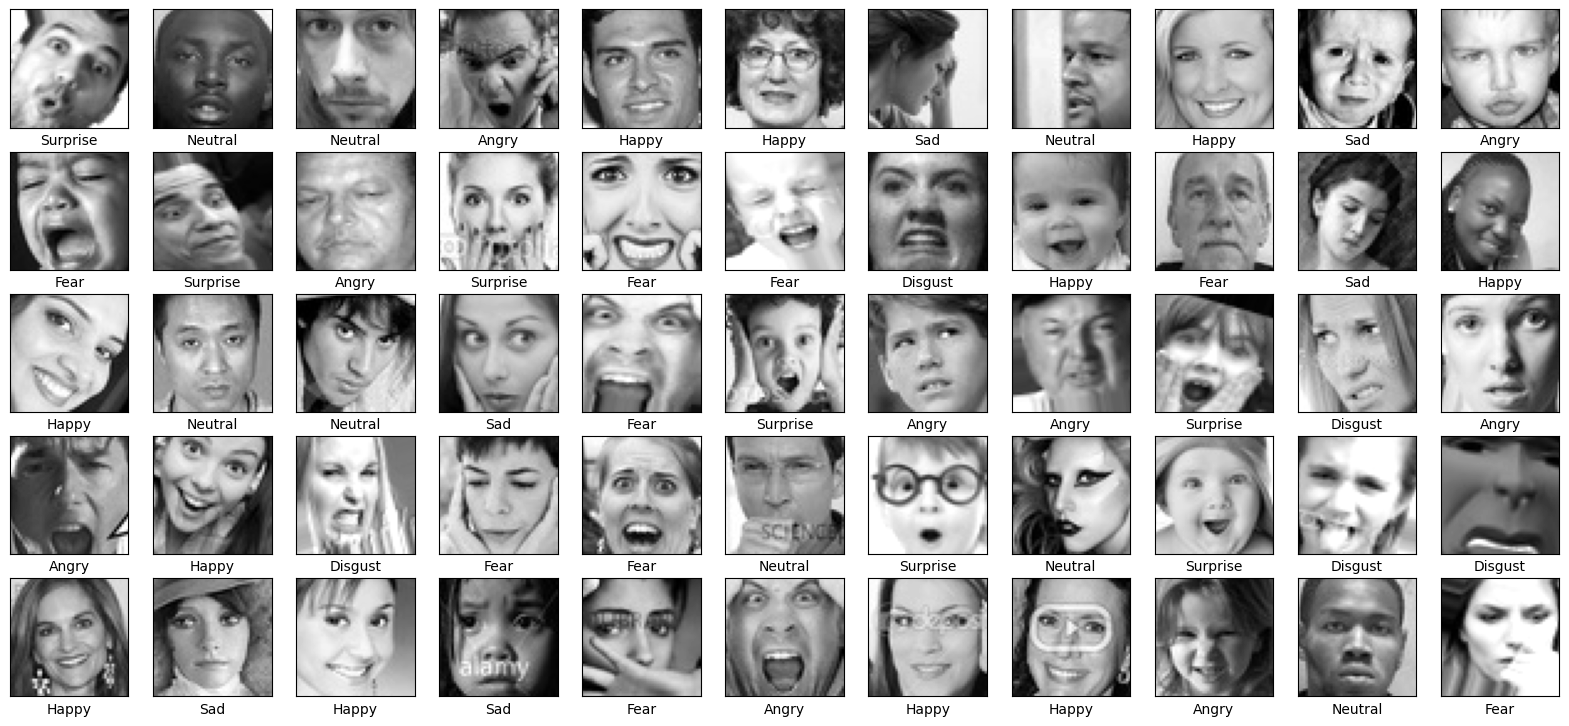

In [170]:
plt.figure(figsize=(20, 20), facecolor='white')
for i in range(len(y_train[:55])):
    plt.subplot(11,11,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap='gray')
    plt.xlabel(class_names[int(y_train[i])])

plt.show()

<font face = 'Century' >

<font face = 'Century' >

<p><a name="Convolutional Neural Network Models"></a></p>

## <font color ="royalblue"> <font face = 'Century' > Convolutional Neural Network Models

In [171]:
X_train.shape[1:]

(48, 48, 1)

<p><a name="First simple CNN model"></a></p>

### <font color ="royalblue"><font face = 'Century' > First Simple CNN Model:

<font face = 'Century'> To test a simple model, let's use the following configuration:
- Two convolutional layers
- Two MaxPooling layers
- Kernel size of 3x3
- One dense layer with 128 neurons

In [172]:
def simple_model(input_shape, num_classes, optimizer='adam', compile=True):
  print(f'Image size: {input_shape[0]}')
  print(f'Number of classes: {num_classes}')

  inputs = Input(shape = input_shape, name = 'Input_layer')
  x = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
  x = MaxPooling2D()(x)
  x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = MaxPooling2D()(x)
  x = Flatten()(x)
  x = Dense(128, activation = 'relu')(x)
  outputs = Dense(num_classes, activation = 'softmax', name = 'Output_layer')(x)

  model = Model(inputs=inputs, outputs=outputs)

  if compile:
    print('Compiling model...')

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  return model

In [173]:
model_A = simple_model(X_train.shape[1:], num_classes=len(class_names))
model_A.summary()

Image size: 48
Number of classes: 7
Compiling model...


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_layer (Dense)                 │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,199,495 (4.58 MB)

 Trainable params: 1,199,495 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [174]:
history_A = model_A.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.2744 - loss: 1.8005 - val_accuracy: 0.3995 - val_loss: 1.5784
Epoch 2/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4315 - loss: 1.4932 - val_accuracy: 0.4401 - val_loss: 1.4558
Epoch 3/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5009 - loss: 1.3278 - val_accuracy: 0.4785 - val_loss: 1.3697
Epoch 4/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5440 - loss: 1.2231 - val_accuracy: 0.4864 - val_loss: 1.3441
Epoch 5/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5843 - loss: 1.1191 - val_accuracy: 0.5024 - val_loss: 1.3232
Epoch 6/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6357 - loss: 1.0040 - val_accuracy: 0.4953 - val_loss: 1.3733
Epoch 7/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6764 - loss: 0.9020 - val_accuracy: 0.4963 - val_loss: 1.4423
Epoch 8/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7084 - loss: 0.8057 - val_accuracy: 

In [175]:
model_A.evaluate(X_test, y_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5656 - loss: 3.1537


[3.607910394668579, 0.4949846863746643]

<font face = 'Century'>

<p><a name="Custom CNN model architectures"></a></p>

### <font color ="royalblue"><font face = 'Century' > Custom CNN Model Architectures:

<font face = 'Century'> Let's create a set of functions to streamline the training and evaluation process across different models.

> <font face = 'Century'> _Function to plot accuray and loss_

In [176]:
def acc_loss_plot(history, model):
  fig, axs = plt.subplots(1, 2, figsize=(15, 4))

  plt.title(f'{model}')

  # Accuracy
  axs[0].plot(history.history['accuracy'], label='accuracy')
  axs[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_ylim([0, 1])
  axs[0].legend(loc='lower right')
  axs[0].set_title("Accuracy")

  # Loss
  axs[1].plot(history.history['loss'], label='loss')
  axs[1].plot(history.history['val_loss'], label = 'val_loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')
  axs[1].set_ylim([0, 2])
  axs[1].legend(loc='upper right')
  axs[1].set_title("Loss")

  print('Model evaluation:')
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
  print('')
  return

> <font face = 'Century'> **_Function to create custom models_**

<font face = 'Century'> To streamline testing different CNN architectures, I've defined a custom function that includes various layers commonly used to enhance model performance, such as dropout and batch normalization. This function was developed after experimenting with several architectures, allowing me to efficiently test and compare models by building on a flexible yet optimized base structure.

In [177]:
def custom_CNN_model(input_shape, num_classes, n_conv_layers=3, kernel_size=3, n_dense_layers=2,
                     n_neurons=512, max_pooling=True, dropout_conv=None, dropout_dense=None,
                     batch_normalization=False):

  print(f'Image size: {input_shape[0]}')
  print(f'Number of classes: {num_classes}')

  inputs = Input(shape = input_shape, name = 'Input_layer')

  # Conv layer
  # - Input
  x = Conv2D(32, 3, padding = 'same')(inputs)

  if batch_normalization:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)
  if max_pooling:
    x = MaxPooling2D()(x)

  # - Hidden layers
  for i in range(2, n_conv_layers + 1):
    n_filters = 32 * i
    if n_filters == 96:
        n_filters = 128
    x = Conv2D(n_filters, kernel_size, padding = 'same')(x)

    if batch_normalization:
      x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if max_pooling:
      x = MaxPooling2D()(x)
    if dropout_conv is not None:
      x = Dropout(dropout_conv)(x)

  # Flatten layer
  x = Flatten()(x)

  # Fully-connected layers
  n_neurons = n_neurons
  for i in range(1, n_dense_layers + 1):
    x = Dense(n_neurons)(x)
    n_neurons = int(n_neurons/2)

    if batch_normalization:
      x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_dense is not None:
      x = Dropout(dropout_dense)(x)

  outputs = Dense(num_classes, activation = 'softmax', name = 'Output_layer')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

<font face = 'Century'> Additionally, for training the model going forward, I'll implement the _Adam_ optimizer with a customized learning rate to enhance performance. I'll also add early stopping to stop training when the model stops improving. I'll set an appropriate patience value and enable `restore_best_weights=True` to ensure the model reverts to its best performing state.

<font face = 'Century'>Let's define a custom learning rate for the Adam optimizer and implement early stopping to monitor the training process and prevent overfitting.

In [178]:
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [179]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

In [180]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

In [181]:
epochs = 50
batch_size = 64

<font face = 'Century'>

#### <font face = 'Century'><font color ="royalblue"> Model B:

In [182]:
model_B = custom_CNN_model(X_train.shape[1:], num_classes=len(class_names), n_neurons=512, dropout_conv=0.2, dropout_dense=0.3)

Image size: 48
Number of classes: 7


In [183]:
optimizer_B = Adam()
model_B.compile(optimizer=optimizer_B,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [184]:
model_B.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_36 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_layer (Dense)                 │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,585,607 (9.86 MB)

 Trainable params: 2,585,607 (9.86 MB)

 Non-trainable params: 0 (0.00 B)

In [185]:
history_B = model_B.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.2250 - loss: 1.8574 - val_accuracy: 0.3803 - val_loss: 1.6071
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.3850 - loss: 1.5831 - val_accuracy: 0.4635 - val_loss: 1.4074
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4586 - loss: 1.4186 - val_accuracy: 0.5030 - val_loss: 1.3220
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5018 - loss: 1.3012 - val_accuracy: 0.5228 - val_loss: 1.2464
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5368 - loss: 1.2266 - val_accuracy: 0.5347 - val_loss: 1.2197
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5597 - loss: 1.1616 - val_accuracy: 0.5450 - val_loss: 1.2074
Epoch 7/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5771 - loss: 1.1114 - val_accuracy: 0.5470 - val_loss: 1.1926
Epoch 8/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6113 - loss: 1.0453 - val_accuracy:

Model evaluation:
225/225 - 1s - 5ms/step - accuracy: 0.5602 - loss: 1.1537



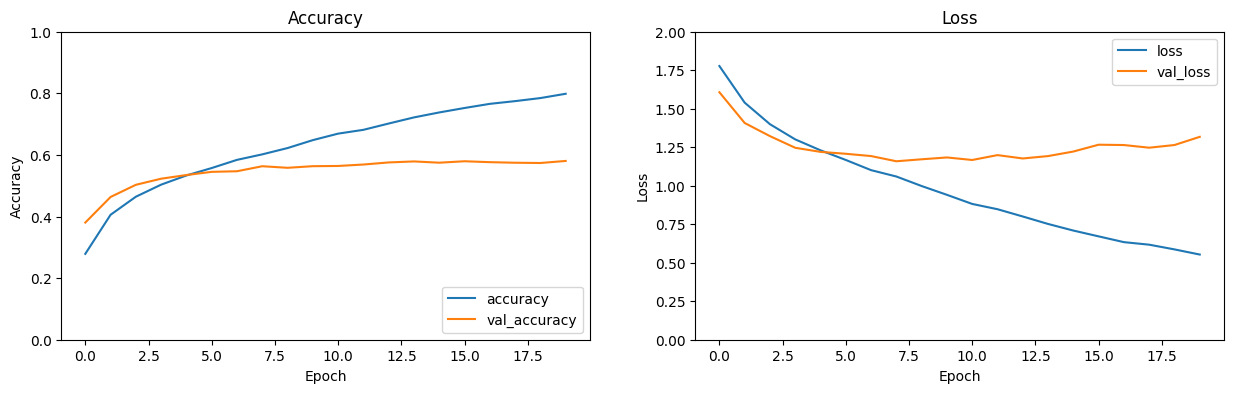

In [186]:
acc_loss_plot(history_B, model_B)

<font face = 'Century'>

#### <font face = 'Century'><font color ="royalblue"> Model C:

In [187]:
model_C = custom_CNN_model(X_train.shape[1:], num_classes=len(class_names), n_neurons=512,
                           dropout_conv=0.2, dropout_dense=0.3, batch_normalization=True)

Image size: 48
Number of classes: 7


In [188]:
optimizer_C = Adam(learning_rate = lr_schedule)
model_C.compile(optimizer=optimizer_C,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [189]:
model_C.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_37 (Activation)           │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_38 (Activation)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_39 (Activation)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_40 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,589,575 (9.88 MB)

 Trainable params: 2,587,591 (9.87 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [190]:
history_C = model_C.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.2691 - loss: 1.9453 - val_accuracy: 0.2465 - val_loss: 1.9132
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4128 - loss: 1.5283 - val_accuracy: 0.4033 - val_loss: 1.5712
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4695 - loss: 1.3718 - val_accuracy: 0.4816 - val_loss: 1.3855
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5158 - loss: 1.2596 - val_accuracy: 0.5278 - val_loss: 1.2392
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5424 - loss: 1.2048 - val_accuracy: 0.5525 - val_loss: 1.1667
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5687 - loss: 1.1327 - val_accuracy: 0.5504 - val_loss: 1.1912
Epoch 7/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5879 - loss: 1.0808 - val_accuracy: 0.4973 - val_loss: 1.4189
Epoch 8/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6181 - loss: 1.0212 - val_accuracy: 

Model evaluation:
225/225 - 1s - 6ms/step - accuracy: 0.5972 - loss: 1.1126



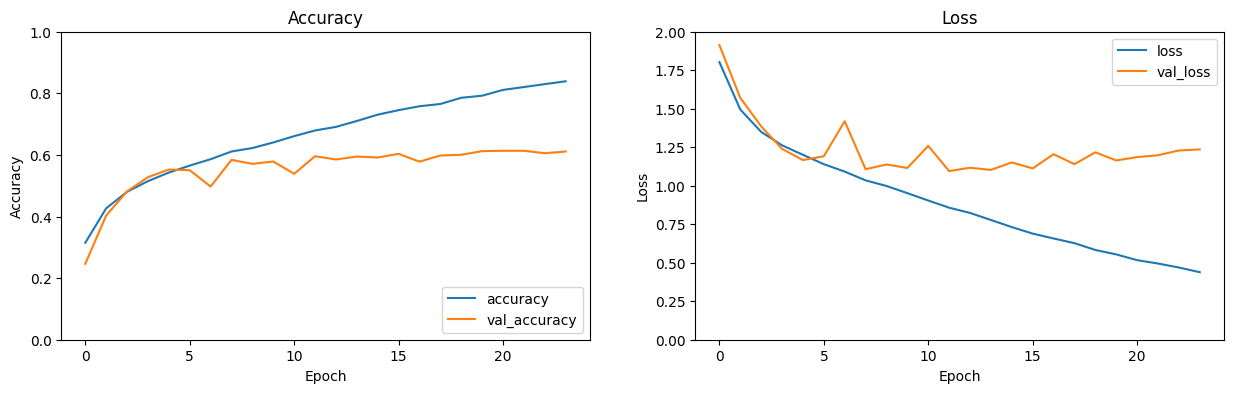

In [191]:
acc_loss_plot(history_C, model_C)

<font face = 'Century'>

#### <font face = 'Century'><font color ="royalblue"> Model D:

In [192]:
model_D = custom_CNN_model(X_train.shape[1:], num_classes=len(class_names), n_neurons=256,
                           dropout_conv=0.2, dropout_dense=0.2, batch_normalization=True,)

Image size: 48
Number of classes: 7


In [193]:
optimizer_D = Adam()
model_D.compile(optimizer=optimizer_D,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [194]:
model_D.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_42 (Activation)           │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_43 (Activation)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_44 (Activation)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_45 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,308,807 (4.99 MB)

 Trainable params: 1,307,591 (4.99 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [195]:
history_D = model_D.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.2859 - loss: 1.8650 - val_accuracy: 0.3100 - val_loss: 1.7060
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4512 - loss: 1.4232 - val_accuracy: 0.4769 - val_loss: 1.3706
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5142 - loss: 1.2825 - val_accuracy: 0.4730 - val_loss: 1.4087
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5449 - loss: 1.1956 - val_accuracy: 0.5082 - val_loss: 1.2973
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5802 - loss: 1.1145 - val_accuracy: 0.5188 - val_loss: 1.2882
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6062 - loss: 1.0443 - val_accuracy: 0.4909 - val_loss: 1.3170
Epoch 7/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6207 - loss: 1.0023 - val_accuracy: 0.5105 - val_loss: 1.3212
Epoch 8/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6476 - loss: 0.9356 - val_accuracy: 

Model evaluation:
225/225 - 2s - 8ms/step - accuracy: 0.3488 - loss: 1.6305



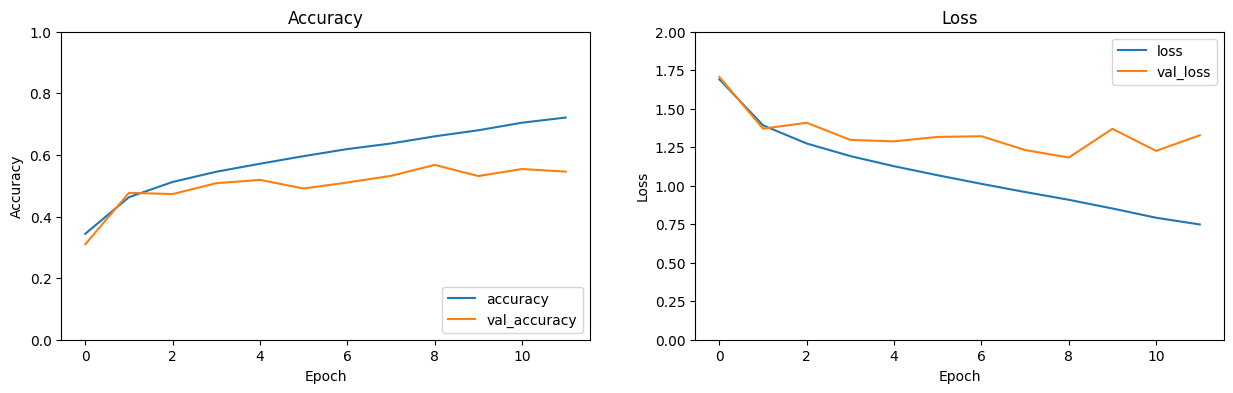

In [196]:
acc_loss_plot(history_D, model_D)

<font face = 'Century'>

#### <font face = 'Century'><font color ="royalblue"> Model E:

<font face = 'Century'>Let's modify the size of the filters

In [197]:
def custom_CNN_model_2(input_shape, num_classes):
  print(f'Image size: {input_shape[0]}')
  print(f'Number of classes: {num_classes}')

  inputs = Input(shape = input_shape, name = 'Input_layer')

  x = Conv2D(64, 3, padding = 'same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.25)(x)

  x = Conv2D(128, 5, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.25)(x)

  x = Conv2D(512, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.25)(x)

  x = Flatten()(x)

  x = Dense(256)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)

  x = Dense(512)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)

  outputs = Dense(num_classes, activation = 'softmax', name = 'Output_layer')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

In [198]:
model_E = custom_CNN_model_2(X_train.shape[1:], num_classes=len(class_names))

Image size: 48
Number of classes: 7


In [199]:
optimizer_E = SGD(learning_rate=0.0005, momentum=0.9)
model_E.compile(optimizer=optimizer_E,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [200]:
model_E.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_47 (Activation)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_48 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_49 (Activation)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,655,815 (21.58 MB)

 Trainable params: 5,652,871 (21.56 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [201]:
history_E = model_E.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[reduce_lr, early_stopping])

Epoch 1/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.2105 - loss: 2.1542 - val_accuracy: 0.2247 - val_loss: 1.9870 - learning_rate: 5.0000e-04
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2718 - loss: 1.8762 - val_accuracy: 0.2774 - val_loss: 1.8920 - learning_rate: 5.0000e-04
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3131 - loss: 1.7757 - val_accuracy: 0.2850 - val_loss: 1.9086 - learning_rate: 5.0000e-04
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3314 - loss: 1.7202 - val_accuracy: 0.2787 - val_loss: 1.9358 - learning_rate: 5.0000e-04
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.3552 - loss: 1.6634 - val_accuracy: 0.3105 - val_loss: 1.7898 - learning_rate: 5.0000e-05
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.3600 - loss: 1.6484 - val_accuracy: 0.3152 - val_loss: 1.7861 - learning_rate: 5.0000e-05
Epoch 7/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/ste

Model evaluation:
225/225 - 2s - 8ms/step - accuracy: 0.2779 - loss: 1.8962



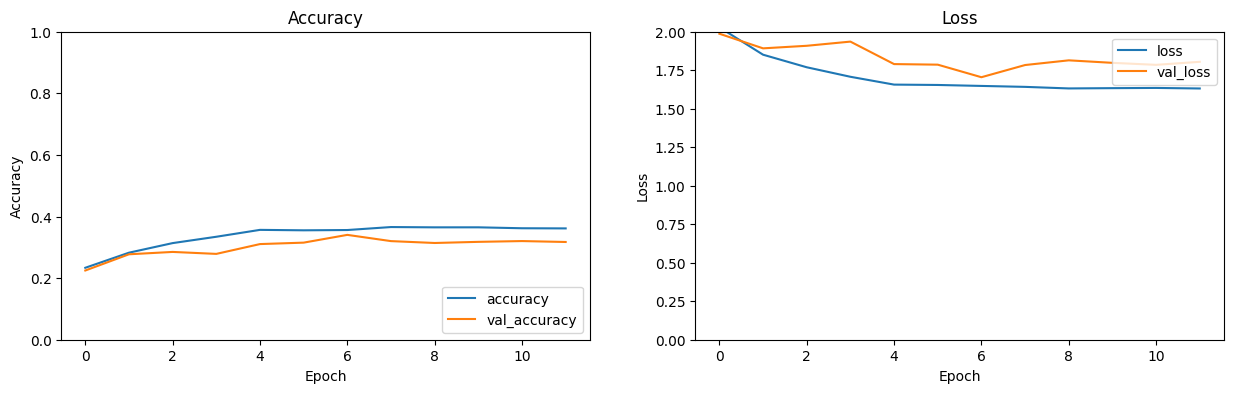

In [202]:
acc_loss_plot(history_E, model_E)

<font face = 'Century'>

#### <font face = 'Century'><font color ="royalblue"> Model F:

In [203]:
def custom_CNN_model_3(input_shape, num_classes):
  print(f'Image size: {input_shape[0]}')
  print(f'Number of classes: {num_classes}')

  inputs = Input(shape = input_shape, name = 'Input_layer')

  x = Conv2D(64, 3, padding = 'same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.25)(x)

  x = Conv2D(128, 5, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.25)(x)

  x = Conv2D(512, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.25)(x)

  x = Conv2D(512, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.25)(x)

  x = Flatten()(x)

  x = Dense(256)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)

  x = Dense(512)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)

  outputs = Dense(num_classes, activation = 'softmax', name = 'Output_layer')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

In [204]:
model_F = custom_CNN_model_3(X_train.shape[1:], num_classes=len(class_names))

Image size: 48
Number of classes: 7


In [205]:
optimizer_F = Adam(learning_rate=0.0005)
model_F.compile(optimizer=optimizer_F,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [206]:
model_F.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_52 (Activation)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_53 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_54 (Activation)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_55 (Activation)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [207]:
history_F = model_F.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[reduce_lr, early_stopping])

Epoch 1/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.2347 - loss: 1.9968 - val_accuracy: 0.2421 - val_loss: 2.0360 - learning_rate: 5.0000e-04
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.3748 - loss: 1.6138 - val_accuracy: 0.3958 - val_loss: 1.6498 - learning_rate: 5.0000e-04
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.4541 - loss: 1.4088 - val_accuracy: 0.2921 - val_loss: 2.8950 - learning_rate: 5.0000e-04
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5126 - loss: 1.2807 - val_accuracy: 0.4364 - val_loss: 1.5317 - learning_rate: 5.0000e-04
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5471 - loss: 1.1742 - val_accuracy: 0.5218 - val_loss: 1.2389 - learning_rate: 5.0000e-04
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.5675 - loss: 1.1331 - val_accuracy: 0.5493 - val_loss: 1.1684 - learning_rate: 5.0000e-04
Epoch 7/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/ste

Model evaluation:
225/225 - 3s - 12ms/step - accuracy: 0.6293 - loss: 1.0270



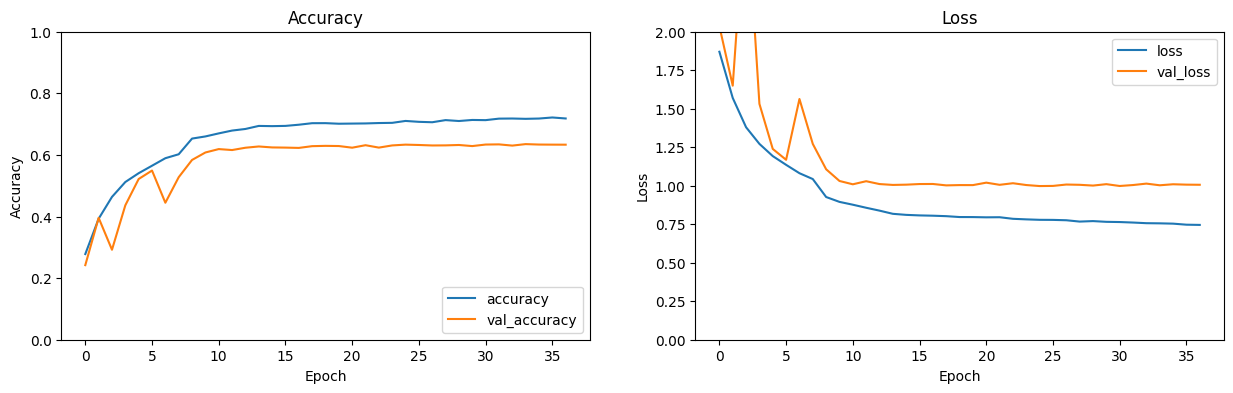

In [208]:
acc_loss_plot(history_F, model_F)

 <font face = 'Century' >

<p><a name="Model Evaluation"></a></p>

## <font color ="royalblue"> <font face = 'Century' > Model Evaluation

<p><a name="Saving Models"></a></p>

### <font color ="royalblue"> <font face = 'Century' > Saving Models

<font face = 'Century' >Run the cell below if you want to save the models.

In [209]:
models = [model_A, model_B, model_C, model_D, model_E, model_F]
model_names = ['model_A', 'model_B', 'model_C', 'model_D', 'model_E', 'model_F']

for i in range(len(models)):
  # models[i].save(f'{model_names[i]}.h5')
  models[i].save(f'{model_names[i]}.keras')

<font face = 'Century' >

<p><a name="Model Evaluation On Test Data"></a></p>

### <font color ="royalblue"> <font face = 'Century' > Model Evaluation On Test Data

<font face = 'Century' > Let's evaluate the models using a batch of 6 random images from the test dataset to assess their predictions and performance.

In [210]:
X_test_shuff, y_test_shuff = unison_shuffled_data(X_test, y_test)

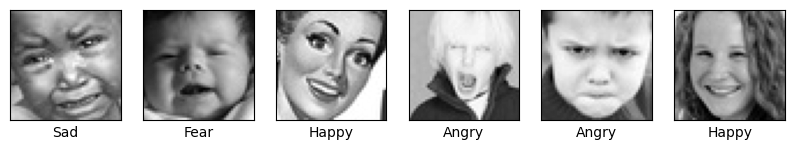

In [211]:
plt.figure(figsize=(10, 10), facecolor='white')
for i in range(len(y_test_shuff[:6])):
    plt.subplot(1,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_shuff[i], cmap='gray')
    plt.xlabel(class_names[int(y_test_shuff[i])])

plt.show()

In [212]:
def predict_batch(batch, model_index):
  #Predicts the class for a batch of images.
  return models[model_index].predict(batch)

for i in range(len(models)):
  #print(f'-- {model_names[i]} --')
  pred = predict_batch(X_test_shuff[:6], i)
  pred = np.argmax(pred, axis=1)
  prediction = [class_names[pred[j]] for j in range(len(pred))]
  print(f'{model_names[i]} ->', prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
model_A -> ['Happy', 'Sad', 'Happy', 'Fear', 'Fear', 'Happy']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
model_B -> ['Happy', 'Sad', 'Happy', 'Angry', 'Angry', 'Happy']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
model_C -> ['Sad', 'Sad', 'Happy', 'Sad', 'Angry', 'Happy']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
model_D -> ['Neutral', 'Happy', 'Happy', 'Sad', 'Neutral', 'Happy']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
model_E -> ['Neutral', 'Neutral', 'Sad', 'Happy', 'Happy', 'Happy']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
model_F -> ['Sad', 'Sad', 'Happy', 'Angry', 'Angry', 'Happy']


<font face = 'Century' >

<p><a name="Performance Evaluation"></a></p>


### <font color ="royalblue"> <font face = 'Century' > Performance Evaluation

<font face = 'Century' >Let's compare the performance of all the models in a graph for better visualization:

In [213]:
models_acc = []
for i in range(len(models)):
  loss, accuracy = models[i].evaluate(X_test, y_test)
  models_acc.append(accuracy)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5656 - loss: 3.1537
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6434 - loss: 1.0127
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7053 - loss: 0.8822
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4449 - loss: 1.5810
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3042 - loss: 2.0355
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7165 - loss: 0.8357


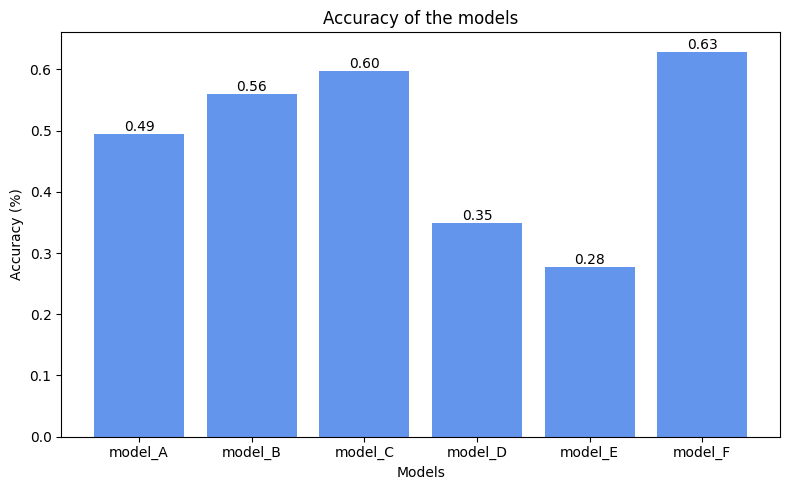

In [214]:
plt.figure(figsize=(8,5))
bars = plt.bar(model_names, models_acc, color = 'cornflowerblue')

for bar in bars:
  height = bar.get_height()
  plt.annotate(f'{height:.2f}',
              (bar.get_x() + bar.get_width() / 2, height),
               ha='center',
               va='bottom')

plt.title('Accuracy of the models')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

<font face = 'Century' >From the best two models, let's analyze the confusion matrix and performance metrics to gain deeper insights into their effectiveness.

In [215]:
best_acc_arg = np.argsort(models_acc)[::-1][:2]

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


---> model_F: 
              precision    recall  f1-score   support

       Happy       0.81      0.84      0.82      1774
         Sad       0.48      0.55      0.51      1247
       Angry       0.59      0.52      0.56       958
     Neutral       0.55      0.63      0.58      1233
    Surprise       0.74      0.79      0.77       831
        Fear       0.53      0.34      0.41      1024
     Disgust       0.52      0.53      0.53       111

    accuracy                           0.63      7178
   macro avg       0.60      0.60      0.60      7178
weighted avg       0.63      0.63      0.62      7178



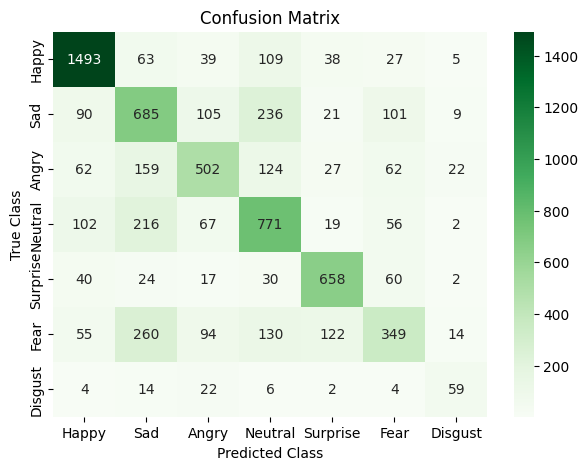

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


---> model_C: 
              precision    recall  f1-score   support

       Happy       0.77      0.82      0.79      1774
         Sad       0.43      0.55      0.48      1247
       Angry       0.60      0.39      0.47       958
     Neutral       0.51      0.64      0.56      1233
    Surprise       0.73      0.78      0.75       831
        Fear       0.54      0.29      0.38      1024
     Disgust       0.54      0.50      0.52       111

    accuracy                           0.60      7178
   macro avg       0.59      0.56      0.56      7178
weighted avg       0.60      0.60      0.59      7178



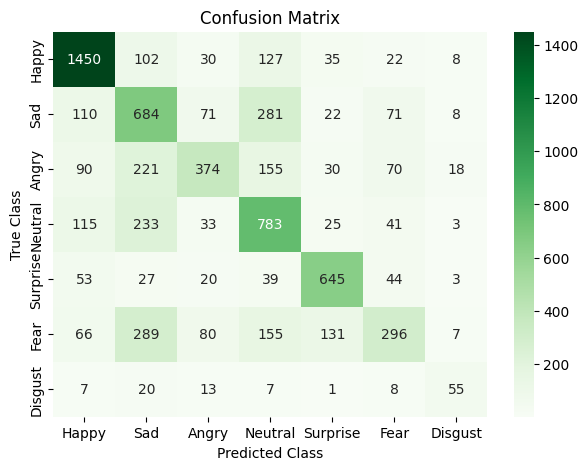

In [216]:
for i in range(len(best_acc_arg)):
  y_pred = np.argmax(models[best_acc_arg[i]].predict(X_test), axis=-1)
  report = classification_report(y_test, y_pred, target_names=class_names)
  print('')
  print('')
  print(f'---> {model_names[best_acc_arg[i]]}: ')
  print(report)

  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(7,5))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title('Confusion Matrix')
  plt.show()

<font face = 'Century' > The confusion matrix and evaluation metrics reveal that the model tends to misclassify certain emotions. Specifically, the F1-score, which combines precision and recall, is lowest for emotions like "fear," "angry," and "sad," indicating that these emotions are more challenging for both models to accurately identify.



<font face = 'Century' >

<p><a name="Different Approaches"></a></p>

## <font color ="royalblue"> <font face = 'Century' > Different Approaches

<p><a name="Feature Extraction + ML Algorithms"></a></p>

### <font color ="royalblue"> <font face = 'Century' > Feature Extraction + ML Algorithms

<font face = 'Century' > Using the models  previously evaluated in the section _Convolutional Neural Network Models_, let's explore a new approach by selecting the top three models. Let's use their layers and weights as feature extractors and apply machine learning algorithms such as `Support Vector Machine (SVM)` and `Random Forest` to evaluate their performance in classifying the extracted features.

<font face = 'Century' >Top three models:




In [217]:
top_acc_arg = np.argsort(models_acc)[::-1][:3]
top_acc_arg

array([5, 2, 1])

<font face = 'Century' > Machine learning algorithms:

In [218]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [219]:
SVM_model = SVC(kernel='linear')
RF_model = RandomForestClassifier(n_estimators=100)

In [220]:
ML_models = [SVM_model, RF_model]

<font face = 'Century' >Let's remove the last layer of each model.

In [221]:
feature_extractor = []

for i in range(len(top_acc_arg)):
  model = models[top_acc_arg[i]]
  layer_ext = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
  feature_extractor.append(layer_ext)
  print(f'{model_names[top_acc_arg[i]]} -> {layer_ext.layers}')

model_F -> [<InputLayer name=Input_layer, built=True>, <Conv2D name=conv2d_36, built=True>, <BatchNormalization name=batch_normalization_42, built=True>, <Activation name=activation_52, built=True>, <MaxPooling2D name=max_pooling2d_36, built=True>, <Dropout name=dropout_46, built=True>, <Conv2D name=conv2d_37, built=True>, <BatchNormalization name=batch_normalization_43, built=True>, <Activation name=activation_53, built=True>, <MaxPooling2D name=max_pooling2d_37, built=True>, <Dropout name=dropout_47, built=True>, <Conv2D name=conv2d_38, built=True>, <BatchNormalization name=batch_normalization_44, built=True>, <Activation name=activation_54, built=True>, <MaxPooling2D name=max_pooling2d_38, built=True>, <Dropout name=dropout_48, built=True>, <Conv2D name=conv2d_39, built=True>, <BatchNormalization name=batch_normalization_45, built=True>, <Activation name=activation_55, built=True>, <MaxPooling2D name=max_pooling2d_39, built=True>, <Dropout name=dropout_49, built=True>, <Flatten name

<font face = 'Century' > Let's pass the data through the feature extractors to obtain the relevant features. At the same time, let's leverage these extracted features to train and evaluate both machine learning models. This will help identify the most effective combination of feature extraction methods and machine learning algorithms, leading to the best performance.






In [222]:
for i, model in enumerate(ML_models):
  print(i, model)

0 SVC(kernel='linear')
1 RandomForestClassifier()


In [223]:
for i, model in enumerate(ML_models):

  print(f'Training and evaluating ML algorithm: {model}')
  print('')

  for j in range(len(feature_extractor)):
    print(f'---> Feature Extractor: {model_names[top_acc_arg[j]]}:')

    # Passing the data through the feature extractor
    features_train = feature_extractor[j].predict(X_train)
    features_train = features_train.reshape((features_train.shape[0], -1))

    features_test = feature_extractor[j].predict(X_test)
    features_test = features_test.reshape((features_test.shape[0], -1))

    # Training the model on the current feature extractor
    model.fit(features_train, y_train)

    # Evaluating the model on the current feature extractor
    y_pred = model.predict(features_test)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
  print('')

Training and evaluating ML algorithm: SVC(kernel='linear')

---> Feature Extractor: model_F:
883/883 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.6110
---> Feature Extractor: model_C:
883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.5933
---> Feature Extractor: model_B:
883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.5644

Training and evaluating ML algorithm: RandomForestClassifier()

---> Feature Extractor: model_F:
883/883 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.6344
---> Feature Extractor: model_C:
883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.6183
---> Feature Extractor: model_B:
883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.5759



In [224]:
for i in range(len(top_acc_arg)):
  print('Initial Model Accruracy:')
  print(f'{model_names[top_acc_arg[i]]} ->', models_acc[top_acc_arg[i]])

Initial Model Accruracy:
model_F -> 0.6292839050292969
Initial Model Accruracy:
model_C -> 0.5972415804862976
Initial Model Accruracy:
model_B -> 0.5601838827133179


<font face = 'Century' > As can be seen, implementing a CNN as a feature extractor and applying an ML algorithm can lead to better performance. When comparing the results, it is evident that the models show some improvement, indicating that the feature extraction process is effectively enhancing the learning process. Among the ML algorithms tested, Random Forest demonstrated the best performance, outperforming other models in terms of accuracy.

<p><a name="Transfer Learning"></a></p>

### <font color ="royalblue"> <font face = 'Century' > Transfer Learning


<font face = 'Century' > Let's use the MobileNetV2 model and apply transfer learning to redefine the architecture. By fine-tuning the model, it is possible to improve its performance, starting with pre-trained weights to leverage existing knowledge and achieve better results. Let's see what we obtain:

In [54]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the pre-trained layers
for layer in base_model.layers:
  layer.trainable = False

# Create a new model on top of the pre-trained base
inputs = Input(shape=(48, 48, 1))
x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(inputs)  # Convert in three channels
x = tf.keras.layers.Resizing(32, 32)(x)
x = base_model(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model_TL = Model(inputs=inputs, outputs=outputs)

<ipython-input-54-aad38fe013ca>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [55]:
model_TL.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1, 1, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,885 (9.24 MB)

 Trainable params: 164,901 (644.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [56]:
model_TL.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
history_TL = model_TL.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 131s 140ms/step - accuracy: 0.2337 - loss: 1.8704 - val_accuracy: 0.2559 - val_loss: 1.8276
Epoch 2/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 150s 149ms/step - accuracy: 0.2653 - loss: 1.8210 - val_accuracy: 0.2712 - val_loss: 1.8180
Epoch 3/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 148s 157ms/step - accuracy: 0.2677 - loss: 1.8077 - val_accuracy: 0.2666 - val_loss: 1.8167
Epoch 4/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 123s 135ms/step - accuracy: 0.2780 - loss: 1.7939 - val_accuracy: 0.2642 - val_loss: 1.8163
Epoch 5/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 141s 134ms/step - accuracy: 0.2820 - loss: 1.7882 - val_accuracy: 0.2749 - val_loss: 1.8142
Epoch 6/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 139s 131ms/step - accuracy: 0.2848 - loss: 1.7784 - val_accuracy: 0.2736 - val_loss: 1.8075
Epoch 7/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 114s 129ms/step - accuracy: 0.2949 - loss: 1.7676 - val_accuracy: 0.2754 - val_loss: 1.8087
Epoch 8/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 143s 130ms/step - accuracy: 0.2967 -

In [ ]:
model_TL.evaluate(X_test, y_test)